# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 6

Group Members: Chase Stokes, Alex Huang, Xueqin Lin, Steven Herrera Ternorio

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [ ]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

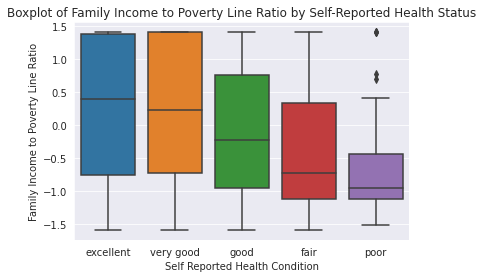

In [ ]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

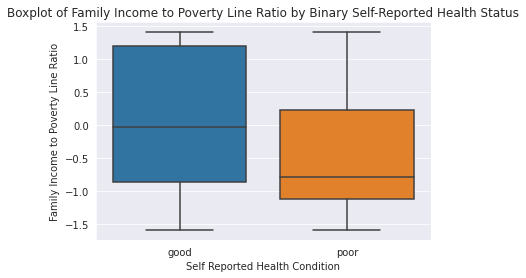

In [ ]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

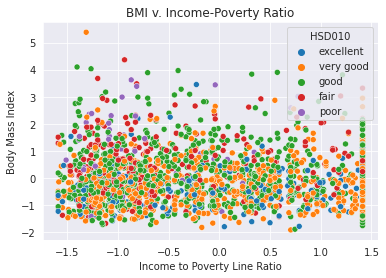

In [ ]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [ ]:
y = nhanes_scaled.loc[:,'HSD010']
y_num = nhanes_scaled.loc[:, 'HSD010'].replace(
    ['excellent', 'very good', 'good', 'fair', 'poor'], [1, 2, 3, 4, 5])
y_bin = nhanes_scaled.loc[:,'HSD010_binary']
y_num_bin = nhanes_scaled.loc[:, 'HSD010_binary'].replace(
    ['good', 'poor'], [1, 0])

In [ ]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

The choice of the number of components was based on results of the variation explained by each component. I first ran the PCA by keeping all components. Based on the results of variation by each component, I will determine the number of components.

In [ ]:
## PCA Analysis
X = nhanes_scaled
X = StandardScaler().fit_transform(X) 
# Instantiate PCA
pca = PCA()
# Determine transformed features
principalComponents_nhanes = pca.fit_transform(X)
# Determine explained variance using explained_variance_ratio_ attribute
exp_var_pca = pca.explained_variance_ratio_

#Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
print(exp_var_pca)

[1.02019612e-01 7.62301114e-02 4.37119204e-02 2.88217170e-02
 2.35713187e-02 1.90163035e-02 1.81085215e-02 1.65559207e-02
 1.55711604e-02 1.53219695e-02 1.31996369e-02 1.21278889e-02
 1.15793671e-02 1.15598097e-02 1.11000658e-02 1.00458298e-02
 9.43222952e-03 9.32323519e-03 8.80416250e-03 8.69021037e-03
 8.40107425e-03 8.26033116e-03 7.96176231e-03 7.82773616e-03
 7.53779323e-03 7.23657144e-03 7.11080739e-03 6.94057200e-03
 6.79371347e-03 6.45721037e-03 6.39647971e-03 6.31755599e-03
 6.21805295e-03 6.17777322e-03 5.92812176e-03 5.77469797e-03
 5.68546881e-03 5.63024512e-03 5.61692644e-03 5.55578734e-03
 5.49481998e-03 5.43106951e-03 5.31583404e-03 5.27999114e-03
 5.21820240e-03 5.16186157e-03 5.10943993e-03 5.01990417e-03
 4.98593377e-03 4.95576889e-03 4.91154746e-03 4.84287943e-03
 4.82170766e-03 4.75045769e-03 4.72203194e-03 4.63836409e-03
 4.62511957e-03 4.58822666e-03 4.51284868e-03 4.48921812e-03
 4.47073111e-03 4.38718004e-03 4.37625134e-03 4.33437985e-03
 4.29189913e-03 4.261155

### Barplot of Components

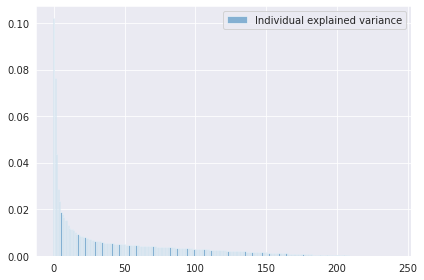

In [ ]:
## Create the barplot of components
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

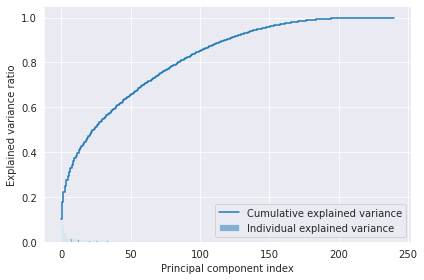

In [ ]:
## create visualization plot with barplot and step plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### How many components will you use to fit a supervised learning model?

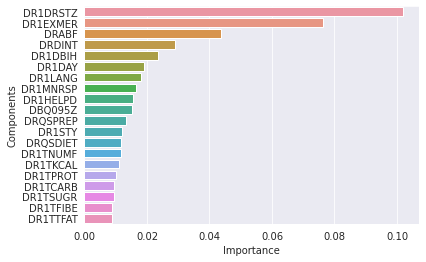

In [ ]:
# filter components based on exp_var_pca
feat_importances = pd.concat([pd.DataFrame(nhanes_scaled.columns),pd.DataFrame(np.transpose(exp_var_pca))], axis = 1)
feat_importances.columns = ["Components", "Importance"]
sns.barplot(x = "Importance", y = "Components", data = feat_importances.nlargest(20, 'Importance'))
plt.show()

Based on results of the variation explained by each component, it appears that "DR1DRSTZ", "DR1EXMER", "DRADBF" are top three components that explain most variations of the PCA model. We will use three components to fit a supervised learning model.

### 2D Scatterplot of the first two components

In [ ]:
ni## Recode target variables
hsd010.unique()
hsd010_2 = hsd010.replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
hsd010_recode = hsd010.replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
hsd010_recode.head()

0    good
1    good
2    good
3    good
4    good
Name: HSD010, dtype: object

In [ ]:
## two components model
pca_two = PCA(n_components=2)
two_principalComponents_nhanes = pca_two.fit_transform(X)
pca_df = pd.DataFrame(data = two_principalComponents_nhanes
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
pca_df.head()

,principal component 1,principal component 2
0,9.527811,-0.816225
1,-5.838340,-3.692570
2,-0.719454,-2.573200
3,3.533627,-2.576982
4,-6.872094,-4.194241


<Figure size 432x288 with 0 Axes>

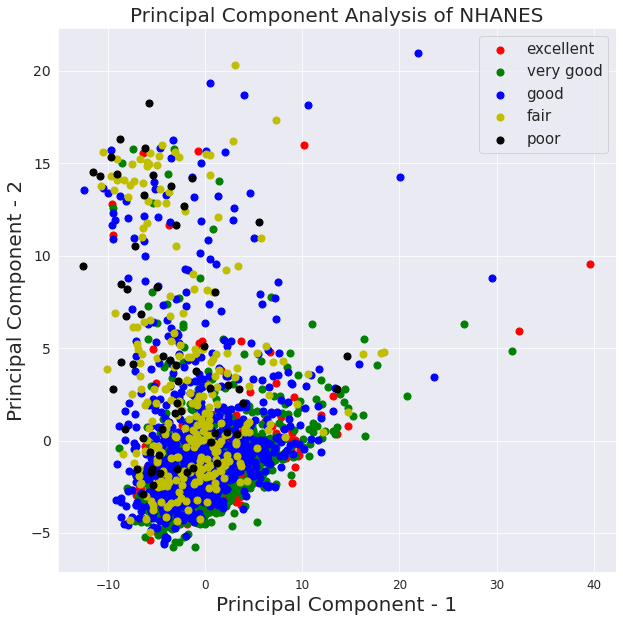

In [ ]:
## scatterplot based on five catergories
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b','y','k']
for target, color in zip(targets,colors):
    indicesToKeep = hsd010_2  == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
plt.legend(targets,prop={'size': 15})
plt.show()

<Figure size 432x288 with 0 Axes>

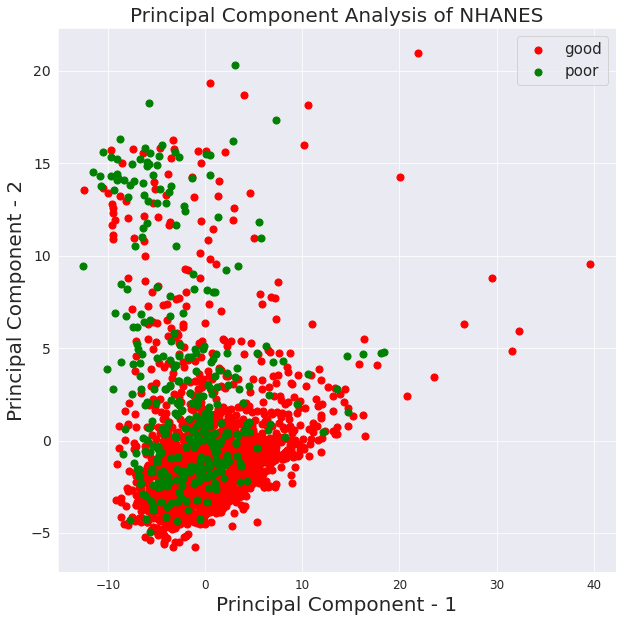

In [ ]:
## scatterplot based on binary catergories
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['good','poor']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = hsd010_recode  == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
plt.legend(targets,prop={'size': 15})
plt.show()

The two scatterplots display the performance of PCA on social determinants of public health outcomes and summarize them with two components. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We chose the clustering algorithm `K-means`, as the data is quite close together. In this case, other clustering algorithms, such as `Agglomerative Clustering` or `Mean Shift` may not be able to accurately capture this closely. We use this image to inform this.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png' style = 'width:50%'>

In [ ]:
X = nhanes_scaled

### Cluster nhanes

In [ ]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

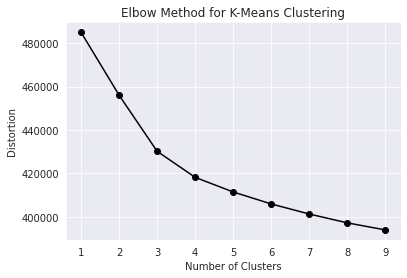

In [ ]:
plt.plot(K, distortions, 'ko-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for K-Means Clustering');

Based on the above plot, the elbow occurs at 3.

In [ ]:
kmean = KMeans(n_clusters=3,
               max_iter=300
               ).fit(X)
kmean.fit(X)
kmean_all = kmean.predict(X)
X['kmean'] = kmean_all

In [ ]:
print("Centers")
print(kmean.cluster_centers_)

print("Labels")
print(kmean.labels_)

for point, label in zip(X, kmean.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.00000000e+00 -5.19935082e-02  0.00000000e+00  1.41420461e-01
   4.08189295e-02 -2.01031136e-01  1.95019476e-01  8.15681008e-02
  -1.25445255e-02 -4.94523331e-02 -7.22245376e-02 -1.63371759e-01
  -1.60466473e-01 -6.05526980e-02 -1.92093997e-01 -2.11891228e-01
  -1.00037323e-01  4.70539131e-02 -2.11208698e-01 -2.15309035e-01
  -1.55498409e-01 -2.16559758e-01 -2.27759744e-01 -8.77742609e-02
  -2.07329879e-01 -1.41107982e-01 -1.68324721e-01 -1.21254925e-01
  -4.07010421e-02 -1.99277051e-01 -1.19245993e-01 -1.69166539e-01
  -1.91854548e-01 -2.25618173e-01 -1.77460646e-01 -1.66049230e-01
  -2.17148446e-01 -9.26012598e-02 -1.67399856e-01 -2.41331729e-01
  -1.25338893e-01 -1.08110721e-01 -2.55803856e-01 -2.73214588e-01
  -2.10805666e-01 -1.76242005e-01 -1.92564353e-01 -2.03476696e-01
  -1.95062894e-01 -1.49459647e-01 -1.79875865e-01  1.46155936e-01
  -1.25401394e-01 -1.31387182e-01 -8.25853210e-02 -1.39218582e-01
  -1.19048515e-02 -1.39325326e-01 -1.78502997e-01 -1.34576173e-01
  

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
X['target'] = y
X['target_bin'] = y_bin

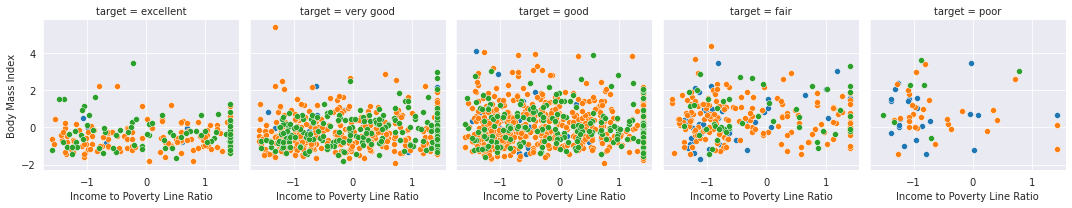

In [ ]:
sea = sns.FacetGrid(X, col = "target", hue = "kmean")
sea.map(sns.scatterplot, "INDFMPIR", "BMXBMI")
sea.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
plt.show()

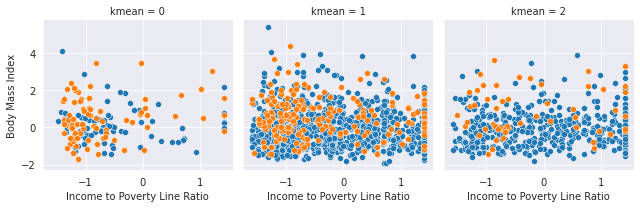

In [ ]:
sea = sns.FacetGrid(X, col = "kmean", hue = "target_bin")
sea.map(sns.scatterplot, "INDFMPIR", "BMXBMI")
sea.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
plt.show()

In [ ]:
X.drop(['target', 'target_bin'], axis = 1, inplace = True)

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
# three components model
pca_three = PCA(n_components=3)
three_principalComponents_nhanes = pca_three.fit_transform(X)
pca_df = pd.DataFrame(data = three_principalComponents_nhanes
             , columns = ['pc 1', 'pc 2', 'pc 3'])

pca_df.head()

,pc 1,pc 2,pc 3
0,9.567812,-0.706175,-1.877978
1,-5.791051,-3.769369,3.807127
2,-0.706994,-2.569355,0.897679
3,3.612467,-2.553912,-3.249199
4,-6.817333,-4.284064,0.890953


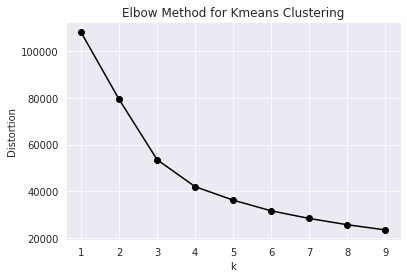

In [ ]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'ko-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Kmeans Clustering');

In [ ]:
kmean = KMeans(n_clusters=3,
               max_iter=300 #default
               ).fit(pca_df)
kmean.fit(pca_df)
kmean_pca = kmean.predict(pca_df)
pca_df['kmean'] = kmean_pca

In [ ]:
poverty = nhanes_scaled['INDFMPIR'].reset_index(drop = True)
bmi = nhanes_scaled['BMXBMI'].reset_index(drop = True)
y.reset_index(drop = True, inplace = True)
y_bin.reset_index(drop = True, inplace = True)

# add columns to pca_df
pca_df['target'] = y
pca_df['target_bin'] = y_bin
pca_df['INDFMPIR'] = poverty
pca_df['BMXBMI'] = bmi

In [ ]:
pca_df.head()

,pc 1,pc 2,pc 3,kmean,target,target_bin,INDFMPIR,BMXBMI
0,9.567812,-0.706175,-1.877978,2,excellent,good,1.412214,-1.001972
1,-5.791051,-3.769369,3.807127,1,excellent,good,-0.642017,-0.618783
2,-0.706994,-2.569355,0.897679,1,very good,good,0.192890,-1.636215
3,3.612467,-2.553912,-3.249199,2,very good,good,1.412214,-0.565929
4,-6.817333,-4.284064,0.890953,1,good,good,0.252955,-0.341301


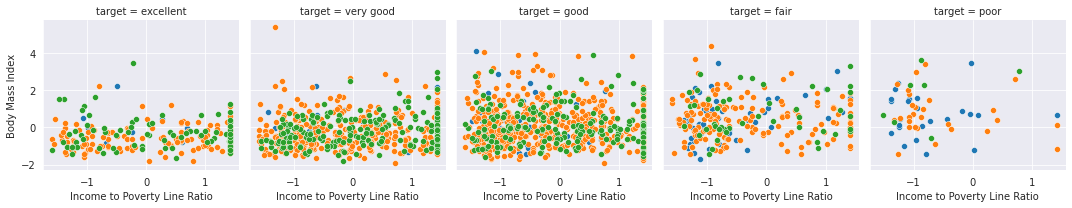

In [ ]:
sea = sns.FacetGrid(pca_df, col = "target", hue = "kmean")
sea.map(sns.scatterplot, "INDFMPIR", "BMXBMI")
sea.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
plt.show()

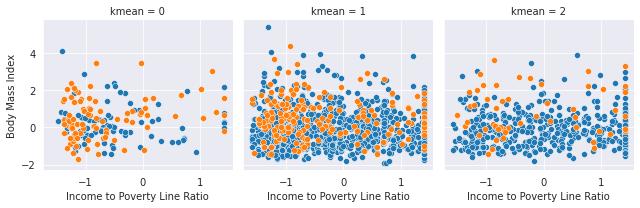

In [ ]:
sea = sns.FacetGrid(pca_df, col = "kmean", hue = "target_bin")
sea.map(sns.scatterplot, "INDFMPIR", "BMXBMI")
sea.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
plt.show()

In [ ]:
# drop columns
pca_df.drop(['target', 'target_bin', 'INDFMPIR', 'BMXBMI', 'kmean'], axis = 1, inplace = True)
pca_df.head()

,pc 1,pc 2,pc 3
0,9.567812,-0.706175,-1.877978
1,-5.791051,-3.769369,3.807127
2,-0.706994,-2.569355,0.897679
3,3.612467,-2.553912,-3.249199
4,-6.817333,-4.284064,0.890953


## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
y = np.where(hsd010_binary=='good',1,0) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['kmean'], axis = 1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
model = Sequential()

model.add(
    Dense(128, input_dim= 241, kernel_initializer= 'random_normal', activation= 'relu')
)

model.add(
    Dense(64)
)

model.add(
    Dense(32)
)

model.add(
    Dense(12)
)

model.add(
    Dense(1,activation='sigmoid')
)
## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=200, verbose=True)

Epoch 1/25
8/8 [==============================] - 1s 35ms/step - loss: 0.5243 - accuracy: 0.7526 - val_loss: 0.4029 - val_accuracy: 0.8469
Epoch 2/25
8/8 [==============================] - 0s 9ms/step - loss: 0.3668 - accuracy: 0.8618 - val_loss: 0.3869 - val_accuracy: 0.8605
Epoch 3/25
8/8 [==============================] - 0s 12ms/step - loss: 0.3013 - accuracy: 0.8753 - val_loss: 0.3535 - val_accuracy: 0.8682
Epoch 4/25
8/8 [==============================] - 0s 12ms/step - loss: 0.2635 - accuracy: 0.8986 - val_loss: 0.3478 - val_accuracy: 0.8702
Epoch 5/25
8/8 [==============================] - 0s 13ms/step - loss: 0.2302 - accuracy: 0.9134 - val_loss: 0.3550 - val_accuracy: 0.8740
Epoch 6/25
8/8 [==============================] - 0s 9ms/step - loss: 0.1979 - accuracy: 0.9199 - val_loss: 0.3605 - val_accuracy: 0.8702
Epoch 7/25
8/8 [==============================] - 0s 12ms/step - loss: 0.1655 - accuracy: 0.9367 - val_loss: 0.3788 - val_accuracy: 0.8682
Epoch 8/25
8/8 [=============

### Neural Network on Principal Components

In [ ]:
y = np.where(hsd010_binary=='good',1,0) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca_df # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
model = Sequential()

model.add(
    Dense(128, input_dim= 3, kernel_initializer= 'random_normal', activation= 'relu')
)

model.add(
    Dense(64)
)

model.add(
    Dense(32)
)

model.add(
    Dense(12)
)

model.add(
    Dense(1,activation='sigmoid')
)
## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=200, verbose=True)

Epoch 1/25
8/8 [==============================] - 1s 36ms/step - loss: 0.5909 - accuracy: 0.6822 - val_loss: 0.4078 - val_accuracy: 0.8508
Epoch 2/25
8/8 [==============================] - 0s 11ms/step - loss: 0.4027 - accuracy: 0.8340 - val_loss: 0.4062 - val_accuracy: 0.8488
Epoch 3/25
8/8 [==============================] - 0s 10ms/step - loss: 0.4029 - accuracy: 0.8417 - val_loss: 0.3893 - val_accuracy: 0.8585
Epoch 4/25
8/8 [==============================] - 0s 10ms/step - loss: 0.3870 - accuracy: 0.8482 - val_loss: 0.3827 - val_accuracy: 0.8547
Epoch 5/25
8/8 [==============================] - 0s 8ms/step - loss: 0.3775 - accuracy: 0.8475 - val_loss: 0.3744 - val_accuracy: 0.8624
Epoch 6/25
8/8 [==============================] - 0s 9ms/step - loss: 0.3737 - accuracy: 0.8463 - val_loss: 0.3733 - val_accuracy: 0.8585
Epoch 7/25
8/8 [==============================] - 0s 7ms/step - loss: 0.3715 - accuracy: 0.8411 - val_loss: 0.3714 - val_accuracy: 0.8585
Epoch 8/25
8/8 [==============

### Neural Network on Principal Components + Cluster Membership

In [ ]:
y = np.where(hsd010_binary=='good',1,0) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = kmean_pca # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
model = Sequential()

model.add(
    Dense(128, input_dim= 1, kernel_initializer= 'random_normal', activation= 'relu')
)

model.add(
    Dense(64)
)

model.add(
    Dense(32)
)

model.add(
    Dense(12)
)

model.add(
    Dense(1,activation='sigmoid')
)
## Add any additional layers you wish here

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=200, verbose=True)

Epoch 1/25
8/8 [==============================] - 2s 52ms/step - loss: 0.6196 - accuracy: 0.7429 - val_loss: 0.4985 - val_accuracy: 0.8488
Epoch 2/25
8/8 [==============================] - 0s 14ms/step - loss: 0.4566 - accuracy: 0.8359 - val_loss: 0.4051 - val_accuracy: 0.8488
Epoch 3/25
8/8 [==============================] - 0s 13ms/step - loss: 0.4270 - accuracy: 0.8359 - val_loss: 0.4126 - val_accuracy: 0.8488
Epoch 4/25
8/8 [==============================] - 0s 19ms/step - loss: 0.4281 - accuracy: 0.8359 - val_loss: 0.4048 - val_accuracy: 0.8488
Epoch 5/25
8/8 [==============================] - 0s 13ms/step - loss: 0.4212 - accuracy: 0.8359 - val_loss: 0.4074 - val_accuracy: 0.8488
Epoch 6/25
8/8 [==============================] - 0s 13ms/step - loss: 0.4216 - accuracy: 0.8359 - val_loss: 0.4062 - val_accuracy: 0.8488
Epoch 7/25
8/8 [==============================] - 0s 13ms/step - loss: 0.4219 - accuracy: 0.8359 - val_loss: 0.4045 - val_accuracy: 0.8488
Epoch 8/25
8/8 [===========

The neural network model that utilized all standardised data yielded the most accurate results.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is an approach to summarizing variation among observations by reducing the number of features, while clustering is a method to find groups (or clusters) of observations based on how dis/similar the observations are between groups. There is no reduction in “dimensional representation” in clustering, while there is in PCA.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?


We did notice the advantage as combining PCA and clustering permits several clusters with centers in different locations.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can help in many ways. One way is to reduce the possibility of collinearity (using the PCA method) between different variables. This is important when working with “big data” given the large amounts of variables since we do not want to overfit the data when checking with validation sets. Another way using unsupervised techniques is helpful is by finding patterns between different observations. In some cases, not all observations can be regressed against a Y variable using the same X variables. Performing multi-level regression, informed by the unsupervised method (such as clustering), can increase the performance of the supervised model.